# import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

# figure C

# figure D

(-20.0, 20.0)

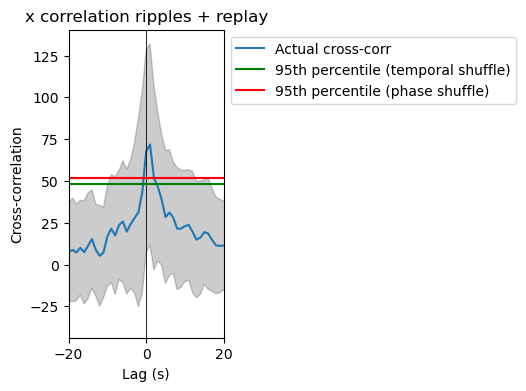

In [3]:


data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\ripple_replay_xcorr_plot_data.npz", allow_pickle=True)

mean_x = data["mean_x"]
mean_y = data["mean_y"]
st_dev = data["st_dev"]

mean_y_shuf = data["mean_y_shuf"]
mean_y_shuf_2 = data["mean_y_shuf_2"]


plt.figure(figsize=(2,4))
plt.fill_between(mean_x, convolve_movmean(mean_y,2) - st_dev, convolve_movmean(mean_y,2) + st_dev, alpha=0.2, color='k')
plt.plot(mean_x, convolve_movmean(mean_y,2), label='Actual cross-corr')
plt.axvline(0, color='k', linewidth=0.6)
plt.axhline(np.percentile(mean_y_shuf,95),color = 'green',label='95th percentile (temporal shuffle)')
plt.axhline(np.percentile(mean_y_shuf_2,95),color = 'red',label='95th percentile (phase shuffle)')
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('x correlation ripples + replay')
plt.xlim(-20,20)


# figure E

(-20.0, 20.0)

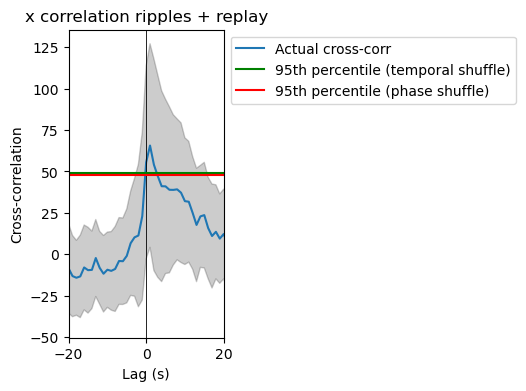

In [4]:


data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\spindle_replay_xcorr_plot_data.npz", allow_pickle=True)

mean_x = data["mean_x"]
mean_y = data["mean_y"]
st_dev = data["st_dev"]

mean_y_shuf = data["mean_y_shuf"]
mean_y_shuf_2 = data["mean_y_shuf_2"]


plt.figure(figsize=(2,4))
plt.fill_between(mean_x, convolve_movmean(mean_y,2) - st_dev, convolve_movmean(mean_y,2) + st_dev, alpha=0.2, color='k')
plt.plot(mean_x, convolve_movmean(mean_y,2), label='Actual cross-corr')
plt.axvline(0, color='k', linewidth=0.6)
plt.axhline(np.percentile(mean_y_shuf,95),color = 'green',label='95th percentile (temporal shuffle)')
plt.axhline(np.percentile(mean_y_shuf_2,95),color = 'red',label='95th percentile (phase shuffle)')
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('x correlation ripples + replay')
plt.xlim(-20,20)


# figure G

In [12]:
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\ripple_replay_linkage_hist_plot_data.npz", allow_pickle=True)

bins = data["bins"]
bin_centres = data["bin_centres"]

mean_all_z_data = data["mean_all_z_data"]
std_all_z_data = data["std_all_z_data"]

all_rand_ripples_z_data = data["all_rand_ripples_z_data"]
all_rand_replay_z_data = data["all_rand_replay_z_data"]


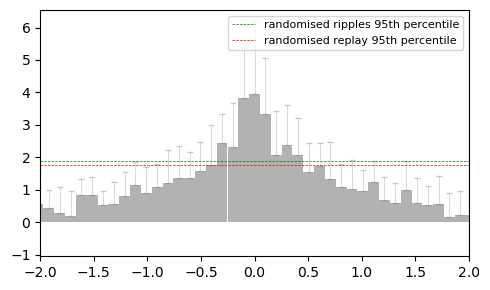

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Bin widths
widths = np.diff(bins)

# Error bar style
error_style = dict(
    ecolor="grey",
    elinewidth=0.5,
    capsize=2,
    alpha=0.4
)

# Main bar plot
ax.bar(
    bin_centres,
    mean_all_z_data,
    width=widths,
    yerr=[np.zeros_like(std_all_z_data), std_all_z_data],
    align="center",
    alpha=0.6,
    color="grey",
    error_kw=error_style
)

# 95th percentile thresholds
ripples_95 = np.percentile(
    np.mean(all_rand_ripples_z_data, axis=0),
    95
)

replay_95 = np.percentile(
    np.mean(all_rand_replay_z_data, axis=0),
    95
)

ax.axhline(
    ripples_95,
    color="green",
    lw=0.5,
    ls="--",
    label="randomised ripples 95th percentile"
)

ax.axhline(
    replay_95,
    color="red",
    lw=0.5,
    ls="--",
    label="randomised replay 95th percentile"
)

# Formatting
ax.set_xlim(-2, 2)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


# figure H

Text(0.5, 1.0, 'percentage of replay linked to SW-R')

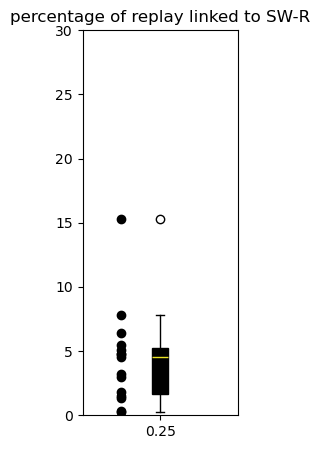

In [7]:
all_prop_replay_linked_to_SWR= [0.05485232067510549,
 0.06429780033840947,
 0.047400611620795105,
 0.0024410089503661514,
 0.01366742596810934,
 0.04520625353173856,
 0.029792746113989636,
 0.050518568082970894,
 0.015184381778741865,
 0.15330739299610896,
 0.018207282913165267,
 0.031914893617021274,
 0.0036429872495446266,
 0.047787610619469026,
 0.07777777777777778]

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_prop_replay_linked_to_SWR)), np.array(all_prop_replay_linked_to_SWR)*100, 'o', color = 'k')
ax.boxplot(np.array(all_prop_replay_linked_to_SWR)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,30)
ax.set_title('percentage of replay linked to SW-R')

# figure I

Text(0.5, 1.0, 'percentage of SW-R linked to replay')

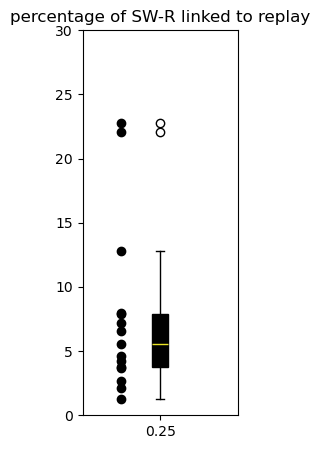

In [10]:
all_proportion_SWR_linked_to_replay = [0.07907542579075426,
 0.06595905989385899,
 0.046370967741935484,
 0.04225352112676056,
 0.22093023255813954,
 0.22737556561085973,
 0.03787878787878788,
 0.07941834451901567,
 0.026845637583892617,
 0.0721331689272503,
 0.012658227848101266,
 0.05537459283387622,
 0.021052631578947368,
 0.12762520193861066,
 0.03685092127303183]

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_proportion_SWR_linked_to_replay)), np.array(all_proportion_SWR_linked_to_replay)*100, 'o', color = 'k')
ax.boxplot(np.array(all_proportion_SWR_linked_to_replay)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,30)
ax.set_title('percentage of SW-R linked to replay')


# figure J

# figure K 

# figure L

# figure M

# figure N

# figure O

# figure P

# figure Q